In [13]:
from topk_sae import FastAutoencoder
import numpy as np
import torch
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [3]:
path_16 = 'checkpoints/16_3072_24_auxk_epoch_50.pth'
path_32 = 'checkpoints/32_6144_48_auxk_epoch_50.pth'
path_64 = 'checkpoints/64_9216_128_auxk_epoch_50.pth'

In [12]:
# Configs for loading the FastAutoencoders
# Set grad to false
torch.set_grad_enabled(False)

model_configs = {
    '16': {
        'path': path_16,
        'd_model': 1536,
        'n_dirs': 3072,
        'k': 16,
        'auxk': 24
    },
    '32': {
        'path': path_32,
        'd_model': 1536,
        'n_dirs': 6144,
        'k': 32,
        'auxk': 48
    },
    '64': {
        'path': path_64,
        'd_model': 1536,
        'n_dirs': 1536 * 6,
        'k': 64,
        'auxk': 128
    }
}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
models = {}
for key, config in model_configs.items():
    model = FastAutoencoder(config['n_dirs'], config['d_model'], config['k'], config['auxk'], multik=0)
    model.load_state_dict(torch.load(config['path'], map_location=device))
    model = model.to(device)
    model.eval()
    models[key] = model

In [14]:
models

{'16': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=3072, bias=False)
   (decoder): Linear(in_features=3072, out_features=1536, bias=False)
 ),
 '32': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=6144, bias=False)
   (decoder): Linear(in_features=6144, out_features=1536, bias=False)
 ),
 '64': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=9216, bias=False)
   (decoder): Linear(in_features=9216, out_features=1536, bias=False)
 )}

In [16]:
# Get all the indices and values across abstracts and save
batch_size = 1024

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for key, ae in models.items():
    k = int(key)

    # Prepare arrays to store results
    num_abstracts = len(abstract_embeddings)
    topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
    topk_values = np.zeros((num_abstracts, k), dtype=np.float32)

    # Process batches
    with torch.no_grad():
        for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
            batch = batch.to(device)
            _, info = ae(batch)
            
            start_idx = i * batch_size
            end_idx = start_idx + batch.size(0)
            
            topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
            topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()

    # Save results
    np.save(f"sae_data/topk_indices_{k}.npy", topk_indices)
    np.save(f"sae_data/topk_values_{k}.npy", topk_values)

    print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [00:08<00:00, 31.54it/s]


Processing complete. Results saved in 'sae_data' folder.


Processing abstracts: 100%|██████████| 266/266 [00:15<00:00, 17.17it/s]


Processing complete. Results saved in 'sae_data' folder.


Processing abstracts: 100%|██████████| 266/266 [00:21<00:00, 12.24it/s]

Processing complete. Results saved in 'sae_data' folder.


## Loading top-k indices and values for each of the models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import networkx as nx

In [3]:
index_value_dict = {}

for k in [16, 32, 64]:
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    print(f"Top-{k} indices shape: {indices.shape}")
    print(f"Top-{k} values shape: {values.shape}")
    index_value_dict[k] = (indices, values)
    print()

Top-16 indices shape: (271492, 16)
Top-16 values shape: (271492, 16)

Top-32 indices shape: (271492, 32)
Top-32 values shape: (271492, 32)

Top-64 indices shape: (271492, 64)
Top-64 values shape: (271492, 64)



Analyzing SAE-16
Computing co-activation matrix...


Computing co-activation: 100%|██████████| 271492/271492 [00:20<00:00, 13183.28it/s]


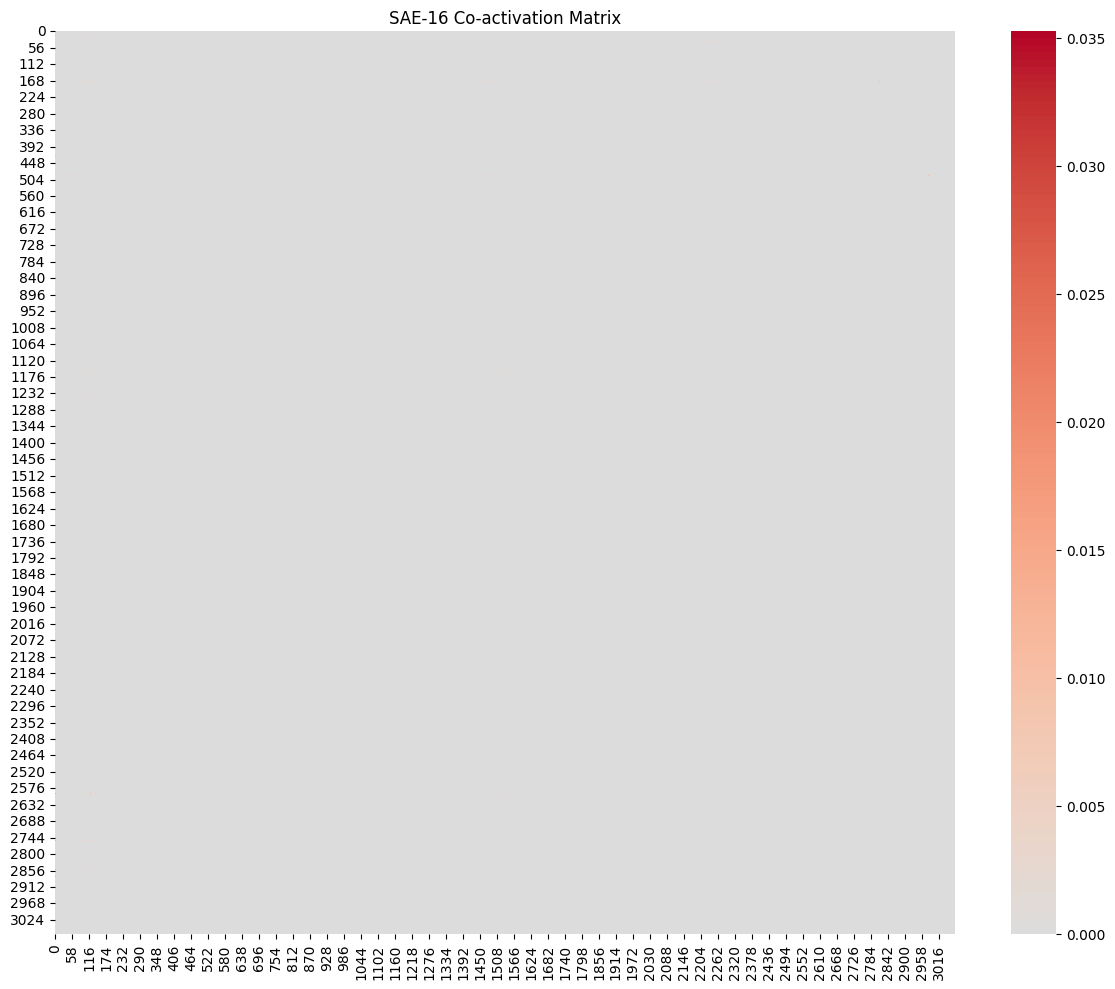

Computing activation correlation matrix...


Computing correlations:   0%|          | 6/3072 [01:38<13:58:51, 16.42s/it]


KeyboardInterrupt: 

In [19]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def load_data(k):
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    return indices, values

def get_total_features(k):
    feature_counts = {16: 3072, 32: 6144, 64: 9216}
    return feature_counts[k]

def compute_co_activation_matrix(indices, k, n_papers):
    n_features = get_total_features(k)
    co_activation = np.zeros((n_features, n_features), dtype=int)
    
    for paper_indices in tqdm(indices, desc="Computing co-activation"):
        for i in paper_indices:
            for j in paper_indices:
                if i != j:
                    co_activation[i, j] += 1
    
    # Normalize by the number of papers
    co_activation = co_activation / n_papers
    return co_activation

def compute_activation_correlation(indices, values, k, n_papers):
    n_features = get_total_features(k)
    correlation_matrix = np.zeros((n_features, n_features))
    
    # Create a sparse matrix of activations
    rows = np.repeat(np.arange(n_papers), k)
    cols = indices.flatten()
    data = values.flatten()
    activation_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(n_papers, n_features))
    
    # Compute correlation for each pair of features
    for i in tqdm(range(n_features), desc="Computing correlations"):
        i_activations = activation_matrix[:, i].toarray().flatten()
        for j in range(i+1, n_features):
            j_activations = activation_matrix[:, j].toarray().flatten()
            
            # Get non-zero entries for both features
            mask = (i_activations != 0) & (j_activations != 0)
            if np.sum(mask) > 1:  # Need at least 2 points for correlation
                corr, _ = spearmanr(i_activations[mask], j_activations[mask])
                correlation_matrix[i, j] = corr
                correlation_matrix[j, i] = corr
    
    return correlation_matrix

def plot_heatmap(matrix, title, filename):
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, cmap='coolwarm', center=0)
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    #plt.close()
    plt.show()

def analyze_sae(k):
    print(f"Analyzing SAE-{k}")
    indices, values = load_data(k)
    n_papers = indices.shape[0]
    
    print("Computing co-activation matrix...")
    co_activation_matrix = compute_co_activation_matrix(indices, k, n_papers)
    plot_heatmap(co_activation_matrix, f"SAE-{k} Co-activation Matrix", f"sae_{k}_co_activation.png")
    
    print("Computing activation correlation matrix...")
    correlation_matrix = compute_activation_correlation(indices, values, k, n_papers)
    plot_heatmap(correlation_matrix, f"SAE-{k} Activation Correlation Matrix", f"sae_{k}_correlation.png")
    
    return co_activation_matrix, correlation_matrix

# Analyze each SAE
for k in [16, 32, 64]:
    co_activation, correlation = analyze_sae(k)
    
    # You can save these matrices for further analysis if needed
    np.save(f"sae_data/sae_{k}_co_activation.npy", co_activation)
    np.save(f"sae_data/sae_{k}_correlation.npy", correlation)

print("Analysis complete. Heatmaps and matrices have been saved.")

In [ ]:
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(k):
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    return indices, values

def get_total_features(k):
    feature_counts = {16: 3072, 32: 6144, 64: 9216}
    return feature_counts[k]

def create_activation_matrix(indices, values, k, n_papers):
    n_features = get_total_features(k)
    rows = np.repeat(np.arange(n_papers), k)
    cols = indices.flatten()
    data = values.flatten()
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_papers, n_features))

def compute_inter_sae_correlation(sae1_matrix, sae2_matrix, k1, k2):
    n_features1 = get_total_features(k1)
    n_features2 = get_total_features(k2)
    correlation_matrix = np.zeros((n_features1, n_features2))
    
    for i in range(n_features1):
        if i % 100 == 0:
            print(f"Processing feature {i} of SAE-{k1}")
        i_activations = sae1_matrix[:, i].toarray().flatten()
        for j in range(n_features2):
            j_activations = sae2_matrix[:, j].toarray().flatten()
            
            # Get non-zero entries for both features
            mask = (i_activations != 0) & (j_activations != 0)
            if np.sum(mask) > 1:  # Need at least 2 points for correlation
                corr, _ = spearmanr(i_activations[mask], j_activations[mask])
                correlation_matrix[i, j] = corr
    
    return correlation_matrix

def plot_heatmap(matrix, title, filename):
    plt.figure(figsize=(20, 16))
    sns.heatmap(matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.xlabel("Features of wider SAE")
    plt.ylabel("Features of narrower SAE")
    plt.tight_layout()
    #plt.savefig(filename, dpi=300)
    #plt.close()
    plt.show()

# Load data and create activation matrices for all SAEs
sae_data = {}
for k in [16, 32, 64]:
    indices, values = load_data(k)
    n_papers = indices.shape[0]
    sae_data[k] = create_activation_matrix(indices, values, k, n_papers)

# Compute and visualize inter-SAE correlations
sae_pairs = [(16, 32), (16, 64), (32, 64)]

for k1, k2 in sae_pairs:
    print(f"Computing correlations between SAE-{k1} and SAE-{k2}")
    correlation_matrix = compute_inter_sae_correlation(sae_data[k1], sae_data[k2], k1, k2)
    
    # Save correlation matrix
    #np.save(f"sae_{k1}_{k2}_correlation.npy", correlation_matrix)
    
    # Plot heatmap
    plot_heatmap(correlation_matrix, f"Feature Correlations: SAE-{k1} vs SAE-{k2}", f"sae_{k1}_{k2}_correlation_heatmap.png")

print("Analysis complete. Correlation matrices and heatmaps have been saved.")